---

# Part 4: Inferential Visualizations and Business Recommendations

---

## Notebook Summary

This notebook will take the final production model from Part 3's model tuning and will do some final evaluation of the model assumptions and errors through visualization. Then, I will make final business recommendations based on our production model with any necessary cautions illuminated by errors or violations in our assummptions. Included in this notebook, the reader will find:

* Production Model Overview
* Feature Loadings
* Inferential Visualizations
* Business Recommendations

---

## Production Model Overview

In this section, I will review the final production modelfrom the conclusion of Part 3. The reader will recall that ultimately six final features were selected, of which four were directly related to the square footage of key home features to correlate highly with maximum sales price. The model is reproduceed below.

In [22]:
# import requisite libraries and modules for linear regression and evaluation metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pandas.plotting import table

In [2]:
# creates the standard scaler and linear regression Pipeline
ss_pipe = Pipeline([
        ('sc', StandardScaler()),
        ('lr', LinearRegression())
    ])

In [3]:
# fits a standard scaled linear regression and returns a series of the correlation coefficients
def get_lr(X_train, y_train):
    ss_pipe.fit(X_train, y_train)
    return pd.Series(ss_pipe['lr'].coef_, 
                     index = ss_pipe[:-1]\
                     .get_feature_names_out()
                    ).sort_values(ascending = False)

In [4]:
# reads in preliminary model dataframe
homes_production = pd.read_csv('../datasets/homes_production.csv')

homes_production.head()

,Id,Overall Qual,Gr Liv Area,Year Built,BsmtFin SF 1,Garage Area,Lot Area,SalePrice
0,109,6,1479,1976,533.0,475.0,13517,130500
1,544,7,2122,1996,637.0,559.0,11492,220000
2,153,5,1057,1953,731.0,246.0,7922,109000
3,318,5,1444,2006,0.0,400.0,9802,174000
4,255,6,1445,1900,0.0,484.0,14235,138500


In [5]:
# declare features and target for prelim model, tran/test split and then call LinReg function
X = homes_production.drop(columns = ['Id', 'SalePrice'])
y = homes_production['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_production = get_lr(X_train, y_train)

coefs_production

Overall Qual    35143.958468
Gr Liv Area     22999.960314
Year Built      10528.397422
BsmtFin SF 1    10116.465289
Garage Area      8824.518777
Lot Area         6770.160991
dtype: float64

In [6]:
print(f'Production Model Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Production Model Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Production Model Test Score: {ss_pipe.score(X_test, y_test)}')

Production Model Cross-Validation Score: 0.7544171412819313
Production Model Training Score: 0.7802646444079648
Production Model Test Score: 0.8415366207107722


The reader will recall that the R<sup>2</sup> for the training and test scores were apprxoimately 0.78 and 0.84, respectively. Both evaluation metrics are relatively close and high in comparison to our original baseline model score of -0.00043. This indicates that we have a relatively well-fit model. 

---

## Feature Loadings

Next, I will take a look at the feature loadings based on the correlation coefficients in the standard scaler form. Then, I will revert the coefficients based to their regular units to interpret the feature loadings.

In [7]:
feature_loadings = pd.DataFrame(
    coefs_production.values, 
    index = coefs_production.index, 
    columns = ['Coefficient (St. Devs.)']
)

feature_loadings

,Coefficient (St. Devs.)
Overall Qual,35143.958468
Gr Liv Area,22999.960314
Year Built,10528.397422
BsmtFin SF 1,10116.465289
Garage Area,8824.518777
Lot Area,6770.160991


In [8]:
feature_loadings['Standard Deviation'] = homes_production.drop(columns = ['Id', 'SalePrice']).std().values

feature_loadings

,Coefficient (St. Devs.),Standard Deviation
Overall Qual,35143.958468,1.426271
Gr Liv Area,22999.960314,500.447829
Year Built,10528.397422,30.177889
BsmtFin SF 1,10116.465289,461.195041
Garage Area,8824.518777,216.135102
Lot Area,6770.160991,6742.488909


In [27]:
feature_loadings['Coefficient (Units)'] = round(feature_loadings['Coefficient (St. Devs.)'] / feature_loadings['Standard Deviation'], 2)

feature_loadings = feature_loadings.sort_values(by = 'Coefficient (Units)', ascending = False)

feature_loadings

,Coefficient (St. Devs.),Standard Deviation,Coefficient (Units)
Overall Qual,35143.958468,1.426271,24640.46
Year Built,10528.397422,30.177889,348.88
Gr Liv Area,22999.960314,500.447829,45.96
Garage Area,8824.518777,216.135102,40.83
BsmtFin SF 1,10116.465289,461.195041,21.94
Lot Area,6770.160991,6742.488909,1.00


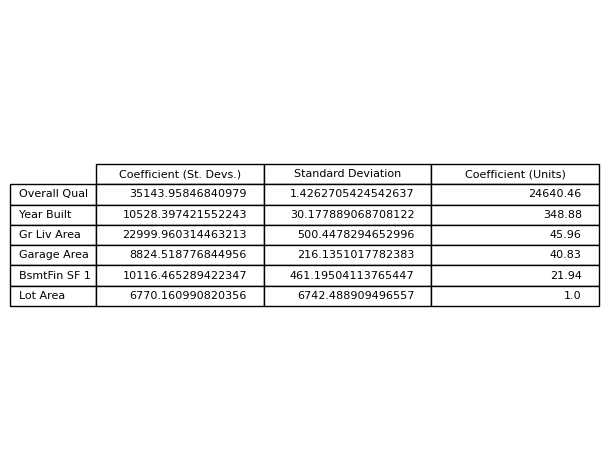

In [28]:
ax = plt.subplot(111, frame_on=False) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
table(ax, feature_loadings, loc='center')
plt.tight_layout()
plt.savefig('../images/feature_loadings_table.png')

In [30]:
feature_loadings_simple = feature_loadings.drop(columns = ['Coefficient (St. Devs.)', 'Standard Deviation'])

feature_loadings_simple

,Coefficient (Units)
Overall Qual,24640.46
Year Built,348.88
Gr Liv Area,45.96
Garage Area,40.83
BsmtFin SF 1,21.94
Lot Area,1.00


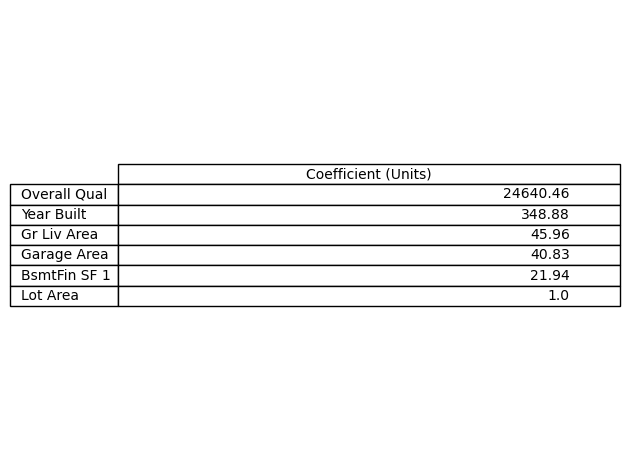

In [35]:
ax = plt.subplot(111, frame_on=False) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
table(ax, feature_loadings_simple, loc='center')
plt.tight_layout()
plt.savefig('../images/feature_loadings_simple_table.png')

In the table above, I have listed the correlation coefficients for each of the six features in the production model. However, I used a standard scaler transformation in my production model to make features on different scales and magnitudes comparable when fitting the multi-linear regression. In the table above, I have included the datasets' standard deviations for each of the features in our production model and then found the correlation coefficient for each of the six features in our production model.

We can interpret the coefficients converted back to their original units to mean for our four area features:

* Holding all else constant, a one square foot increase in the above ground living area is correlated with a \\$45.96 increase in the sale price.
* Holding all else constant, a one square foot increase in the garage area is correlated with a \\$40.83 increase in the sale price.
* Holding all else constant, a one square foot increase in the finished basement is correlated with a \\$21.94 increase in the sale price.
* Holding all else constant, a one square foot increase in the lot area is correlated with a \\$1.00 increase in the sale price.

Let's now look at some of the inferential visualizations to determine errors in our residuals and whether our model assumptions are met.

---

## Inferential Visualizations

First, I will use our production model to make predictions based on the features in the test sample. Then, I will calculate the mean absolute error, mean squared error, and root mean squared error. Then, I will look at the distribution of errors and plot the predicted values versus their residuals to evaluate our model's assumptions for mult-linear regression.

In [10]:
preds_production = ss_pipe.predict(X_test)

resids_production = y_test - preds_production

In [11]:
print(f'The mean absolute error is ${round(metrics.mean_absolute_error(y_test, preds_production), 2)}.')

The mean absolute error is $22428.42.


In [12]:
print(f'The mean squared error is {round(metrics.mean_squared_error(y_test, preds_production), 2)} dollars squared.')

The mean squared error is 972969067.68 dollars squared.


In [13]:
print(f'The root mean squared error is ${round((metrics.mean_squared_error(y_test, preds_production)**0.5), 2)}')

The root mean squared error is $31192.45


The mean absolute error for our production model is \\$22,428.42 which seems like a pretty good average margin for our predictions within a range of 12-13% or so of our mean and median sale prices. Additionally, the root mean squared error is relatively close low as well as at \\$31,192.45.

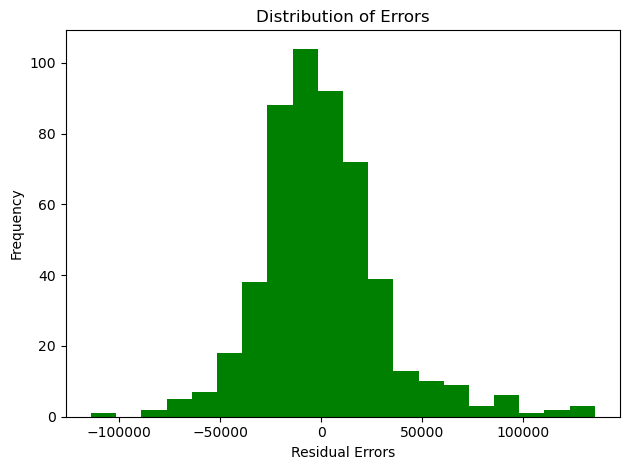

In [36]:
plt.hist(resids_production,
        color = 'green',
        bins = 20)
plt.title('Distribution of Errors')
plt.xlabel('Residual Errors')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../images/distribution_errors.png');

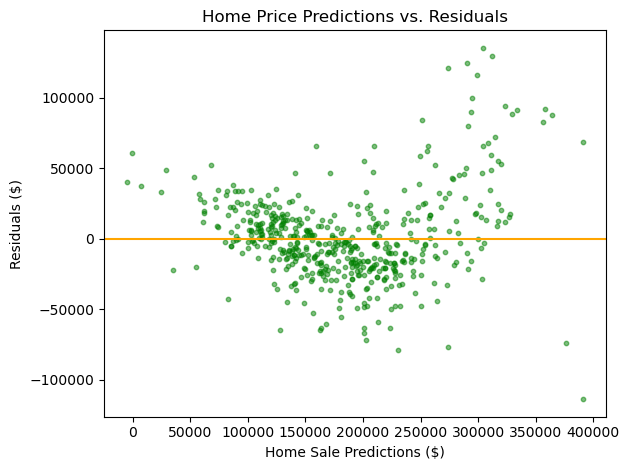

In [37]:
plt.scatter(preds_production,
            resids_production, 
            color = 'green', 
            s = 10, 
            alpha = 0.5)
plt.title('Home Price Predictions vs. Residuals')
plt.xlabel('Home Sale Predictions ($)')
plt.ylabel('Residuals ($)')
plt.axhline(0, color = 'orange')
plt.tight_layout()
plt.savefig('../images/preds_vs_resids.png');

Regarding our inferential visualzations above, we can speak to some of the assumptions inherent in our multi-linear regression model.

1. First, according to some of the scatterplots in the notebook in Part 1, we saw that some of the features which made it into our final production model, namely overall quality, living area, and garage area held linear relationship with the home sale price.

2. Second, our independence of observations might be violated in this model because all of the home sales are from Ames, IA and all these home prices are undoubtely influenced by the overall housing market and moreso within specific neighborhoods. However, we did eliminate the neighborhoods from the final production model, which indicates that we might be able to say with more confidence that the confounding effects of home prices dependent on each other in the same neighborhood.

3. Third, regarding our errors, there does appear to be a mostly normal distribution of errors with the error mean centered close to zero. This indicates that the residual errors are not skewed with respect to actual test values.

4. Fourth, looking at our scatter plot of predicted values versus residuals, we can see that there does not appear to be equal variance of errors. Unfortunately, we do have a heteroscedastic distribution of errors with smaller errors closer to lower home sales and larger errors with more expensive home sales. If we were to have more time to refine the model, we might try eliminating some of the extreme home price outliers to see if the errors could be corrected to be more homoscedastic.

5. Fifth, regarding multi-colinearity, we have accounted for that in our model, constantly looking back at our heatmap in Part 1 to try to effectively eliminate any linear relationships between features whenever possible. We can probably say with some confidence that many of the colinear relationships have been eliminated.

We can see that many of our multi-linear regression assumptions have been met by our model although we might have pause regarding the equal variance of errors and refine our production model later by eliminating outliers and then refining the model.

Lastly, I will make some final business recommendation for our construction company.

---

## Business Recommendations

After extensive consideration of our production model for the square footage of features in new home construction, we can make some final recommendations for the architecture firm which answers the following problem statement:

**For different features of new home construction, which features' square footage has the greatest predictive power in determining the home's sale price? Based on the model developed, how should these features be minimized or maximized to raise the overall sales price?**

I shall summarize our findings and attendant recommendations below:

---

**Finding 1:** The home feature area factors most positively correlated with the home sale price are living area, garage area, finished basement area, and the lot area in that order, with respect to square footage, while holding overall quality and year built constant.

**Recommendation 1:** The architecture firm in Ames, IA should design homes to maximize the size of the living area and garage area first and foremost, as both of these features are positive correlated with an increase in sale price of over \\$40/square foot. For homes with basements, as much of the basement should be finished at the time of construction to correlate with over \\$20/square foot. Lastly, while lot size is positively correlated with the sale price, this is less important as it appears to have only an incremental correlation with sale price. Citing the propert on a large lot is less important than maximimizing those three key area features.

---

**Finding 2:** The overall quality and year built have a very large positve correlation with home sale price with an increase of one unit of quality on a scale of 1-10 correlated with a sale price increase of nearly \\$25,000 and with an increase of being built one year later correlating with a sale price increase of nearly \\$350.

**Recommendation 2:** This study was concerned with the architectural design of new home construction in Ames, IA. Therefore, the year built is irrelevant in any business decisions, but it is important to note that newer homes are highly postiviely correlated with higher sales prices, as one would typically suspect. However, despite eliminating almost all other extraneous non-area related factors in our production model, it appears that we must hold the overall quality constant to say with any cofidence that these other area factors have the positive correlation with home sale price. Therefore, the architecture firm should partner with construction companies and contractors who commit to using high-quality materials in their construction. Additionally, in our final iterations of our model, we can see that the kitchen quality being typical or average, or even just good has a negative correlation with home sale price. Therefore, the architectural firm may take care in working with the construction company or contractors to focus quality materials in the kitchen over other areas of the home, if budget is a concern.

---

**Finding 3:** In our Model 3 iteration, we saw that screen porch area continued to have a relatively large positive correlation with sales price. In contrast all other porches, including open porch, enclosed porch, and three-season porch all had weak positive correlations in Model 1 and were eliminated as factors for consideration in Model 2. The same is true of the wood deck square footage. Although the wood deck square footage had a large positive correlation than the other porches, it was still eliminated as a key feature of our production model in Model 3. Regarding other outdoor amenities, the pool area persitently maintained a negative correlation with home sale price in multiple iterations of our model.

**Recommendation 3:** For outdoor areas, the architectural firm may decide to design with larger screen porches in mind. All other porches add little value to the home sale price. Pools may actually be less desirable, so designing new homes with pools could potentially lower the home sale price. If pools are considered a good fit for the neighborhood, the firm might considering minimizing the size.

---

**Finding 4:** Both second floor, first floor square footage, and total basement square footage all have positive but small correlations with our home sale price. The second floor square footage actually has zero correlation with the home sale price after our Ridge regularization, and we eliminated it as a feature for our production model at the start of Model 1. While the first floor square footage appears to have a larger positive correlation with price, it only persists through our Model 3 iteration as one of the more important factors. Total basement square footage was also elminated in Model 2 as the positive correlation too small to warrant including in our final production model.

**Recommendation 4:** Perhaps surprisingly, the total area of each of the floors seems less important than how the area of the spaces within each floor is designed. For a basement, it seems key to maxmimize the area which is finished in quality. For the first floor, creating a larger living area and perhaps designing a high quality kichen seemm more important than having a larger first floor plan or even more rooms. Lastly, a second floor seems almost negligible in home sales. The firm might consider designing homes without a second floor altogether.